# Group 4's NZ Median Housing Price Predictor

The rising cost of housing and the increasing cost of living are significant challenges that many families in Aotearoa face. As housing prices continue to escalate across various regions, it has become crucial to understand these trends and predict future changes. In this project, we set out to analyze housing price data across Aotearoa and develop a model that predicts median housing costs by region. By leveraging historical data and applying predictive modeling techniques, our aim is to provide insights into future housing prices, offering a valuable tool for understanding and potentially mitigating the pressures of rising housing costs.

We split the workload amongst all 4 of us and each group member was working on different algorithms and different data in some cases.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
import xicorpy as xi
import shap
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## `GradientBoostingRegressor` and the Nelson dataset

In [4]:
nelson = pd.read_csv('datasets/Nelson.csv',index_col=False)
nelson.index = nelson.date
nelson.index = pd.to_datetime(nelson.index)
nelson = nelson[['Nelson', 'lagged']]
nelson.head(5)

,Nelson,lagged
date,,
1992-01-31,115000.0,NaN
1992-02-29,108000.0,115000.0
1992-03-31,115000.0,108000.0
1992-04-30,116000.0,115000.0
1992-05-31,115000.0,116000.0


---

### Other datasets

In [5]:
headers = [
    "Unemployment rate (% s.a.)",
    "Labour force Employed (000s s.a.)",
    "Labour force Employed (y/y%)",
    "Labour force Unemployed (000s s.a.)",
    "Labour force Unemployed (y/y%)",
    "Labour force Total (000s s.a.)",
    "Labour force Total (y/y%)",
    "Not in labour force (000s s.a.)",
    "Not in labour force (y/y%)",
    "Working-age population (000s s.a.)",
    "Working-age population (y/y%)",
    "Labour force participation rate (% s.a.)",
    "Labour cost index (LCI) (Index)",
    "Labour cost index (LCI) (y/y%)",
    "Average hourly earnings (ordinary time and overtime) ($)",
    "Average hourly earnings (ordinary time and overtime) (q/q%)",
    "Average hourly earnings (ordinary time and overtime) (y/y%)",
    "Private sector wages ($)",
    "Private sector wages (q/q%)",
    "Private sector wages (y/y%)",
    "Public sector wages ($)",
    "Public sector wages (q/q%)",
    "Public sector wages (y/y%)"
]

In [6]:
labour = pd.read_excel('datasets/added/labour.xlsx', skiprows=4)
labour.index = labour[labour.columns[0]]
labour.drop(columns=[labour.columns[0]], inplace=True)
labour.index = pd.to_datetime(labour.index)
labour.index.name = 'date'
labour.columns=headers
labour.head(5)

,Unemployment rate (% s.a.),Labour force Employed (000s s.a.),Labour force Employed (y/y%),Labour force Unemployed (000s s.a.),Labour force Unemployed (y/y%),Labour force Total (000s s.a.),Labour force Total (y/y%),Not in labour force (000s s.a.),Not in labour force (y/y%),Working-age population (000s s.a.),...,Labour cost index (LCI) (y/y%),Average hourly earnings (ordinary time and overtime) ($),Average hourly earnings (ordinary time and overtime) (q/q%),Average hourly earnings (ordinary time and overtime) (y/y%),Private sector wages ($),Private sector wages (q/q%),Private sector wages (y/y%),Public sector wages ($),Public sector wages (q/q%),Public sector wages (y/y%)
date,,,,,,,,,,,,,,,,,,,,,
1994-03-31,9.3,1582,3.7,162,-5.2,1744,2.8,983,-1.2,2728,...,1.0,14.94,0.6,0.9,14.29,0.8,1.3,16.94,0.8,1.1
1994-06-30,8.5,1599,4.2,149,-13.8,1749,2.4,988,-0.4,2737,...,0.9,15.06,0.8,1.3,14.45,1.1,1.9,16.97,0.2,1.1
1994-09-30,8.0,1620,4.5,140,-14.2,1761,2.7,988,-0.8,2748,...,1.2,15.05,-0.1,1.7,14.47,0.1,2.7,16.87,-0.6,0.7
1994-12-31,7.6,1643,4.9,135,-17.1,1778,2.8,979,-1.0,2758,...,1.2,15.12,0.5,1.8,14.48,0.1,2.1,17.17,1.8,2.2
1995-03-31,6.8,1662,5.1,121,-25.1,1783,2.1,987,0.3,2770,...,1.3,15.23,0.7,1.9,14.59,0.8,2.1,17.38,1.2,2.6


In [8]:
nelson_labour = nelson.merge(labour.shift(1), on='date', how='inner').dropna()
nelson_labour.head(5)

,Nelson,lagged,Unemployment rate (% s.a.),Labour force Employed (000s s.a.),Labour force Employed (y/y%),Labour force Unemployed (000s s.a.),Labour force Unemployed (y/y%),Labour force Total (000s s.a.),Labour force Total (y/y%),Not in labour force (000s s.a.),...,Labour cost index (LCI) (y/y%),Average hourly earnings (ordinary time and overtime) ($),Average hourly earnings (ordinary time and overtime) (q/q%),Average hourly earnings (ordinary time and overtime) (y/y%),Private sector wages ($),Private sector wages (q/q%),Private sector wages (y/y%),Public sector wages ($),Public sector wages (q/q%),Public sector wages (y/y%)
date,,,,,,,,,,,,,,,,,,,,,
1994-06-30,130000.0,132000.0,9.3,1582.0,3.7,162.0,-5.2,1744.0,2.8,983.0,...,1.0,14.94,0.6,0.9,14.29,0.8,1.3,16.94,0.8,1.1
1994-09-30,133500.0,133000.0,8.5,1599.0,4.2,149.0,-13.8,1749.0,2.4,988.0,...,0.9,15.06,0.8,1.3,14.45,1.1,1.9,16.97,0.2,1.1
1994-12-31,137500.0,141000.0,8.0,1620.0,4.5,140.0,-14.2,1761.0,2.7,988.0,...,1.2,15.05,-0.1,1.7,14.47,0.1,2.7,16.87,-0.6,0.7
1995-03-31,133500.0,135000.0,7.6,1643.0,4.9,135.0,-17.1,1778.0,2.8,979.0,...,1.2,15.12,0.5,1.8,14.48,0.1,2.1,17.17,1.8,2.2
1995-06-30,135000.0,140000.0,6.8,1662.0,5.1,121.0,-25.1,1783.0,2.1,987.0,...,1.3,15.23,0.7,1.9,14.59,0.8,2.1,17.38,1.2,2.6


---

### Initial EDA

In [7]:
xi.compute_xi_correlation(nelson, nelson.Nelson)

,Nelson
Nelson,1.000000
lagged,0.832985


In [9]:
xi.compute_xi_correlation(nelson_labour, nelson_labour.Nelson)

,Nelson
Nelson,1.000000
lagged,0.834059
Unemployment rate (% s.a.),0.146766
Labour force Employed (000s s.a.),0.844272
Labour force Employed (y/y%),0.014824
Labour force Unemployed (000s s.a.),0.067163
Labour force Unemployed (y/y%),0.051426
Labour force Total (000s s.a.),0.863507
Labour force Total (y/y%),0.064223
Not in labour force (000s s.a.),0.776990


---

### Helper Functions

In [13]:
def plot_pred_vs_actual(df, pred):
    plt.plot(df.sort_values(by='date').index, df.sort_values(by='date').Nelson)
    plt.plot(df.sort_values(by='date').index, pred)
    
def print_metrics(df, pred):
    mse = mean_squared_error(pred, df.sort_values(by='date').Nelson)
    rmse = root_mean_squared_error(pred, df.sort_values(by='date').Nelson)
    mae = mean_absolute_error(pred, df.sort_values(by='date').Nelson)
    mdae = median_absolute_error(pred, df.sort_values(by='date').Nelson)
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MDAE: {mdae}')
    
        
def predict_year_end_2024(gbt: GradientBoostingRegressor, last_val, df_nelson):
    df = df_nelson.dropna().copy()
    last_val.rename(columns={'Nelson':'lagged'}, inplace=True)
    pred = None
    for i in range(4):
        pred = gbt.predict(last_val)
        date = df.iloc[-1].name + pd.tseries.offsets.MonthEnd()
        temp = pd.DataFrame([[pred[0], last_val.iloc[0,0]]], index=[date], columns=['Nelson', 'lagged'])
        df = pd.concat([df, temp])
        gbt.fit(df[['lagged']], df[['Nelson']])
        last_val = df[-1:][['Nelson']].copy()
        last_val.rename(columns={'Nelson':'lagged'}, inplace=True)
        
    return pred

---

### Training

In [10]:
train, test = train_test_split(nelson.dropna(), test_size=0.2, shuffle=True)

In [11]:
params = {
    "n_estimators": 200,
    "max_depth": 1,
    "min_samples_split": 5,
    "learning_rate": 0.2,
    "loss": "squared_error",
    "random_state": 42
}


gbf = GradientBoostingRegressor(**params)

In [12]:
gbf.fit(train[['lagged']], train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(learning_rate=0.2, max_depth=1, min_samples_split=5,
                          n_estimators=200, random_state=42)

In [14]:
test_pred = gbf.predict(test[['lagged']])

In [15]:
print_metrics(test, test_pred)

MSE: 57338350136.807304
RMSE: 239454.27567034026
MAE: 179770.59135828086
MDAE: 133036.5315809133


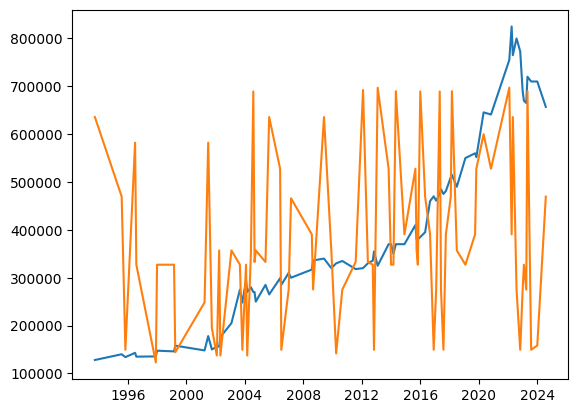

In [16]:
plot_pred_vs_actual(test, test_pred)

### `RandomizedSearchCV`

In [17]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.4),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.5, 0.5)
}

gbr = GradientBoostingRegressor()

In [18]:
rs = RandomizedSearchCV(estimator=gbr, 
                                   param_distributions=param_dist, 
                                   n_iter=200,
                                   cv=5,
                                   random_state=42,
                                   n_jobs=-1)
search = rs.fit(train[['lagged']], train['Nelson'].values)

In [19]:
search.best_params_

{'learning_rate': 0.19019970078781723,
 'max_depth': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 15,
 'n_estimators': 58,
 'subsample': 0.5079831261101071}

In [20]:
test_pred = search.best_estimator_.predict(test[['lagged']])

In [21]:
print_metrics(test, test_pred)

MSE: 57033258942.597084
RMSE: 238816.37075920295
MAE: 178501.7715197787
MDAE: 137055.29377027464


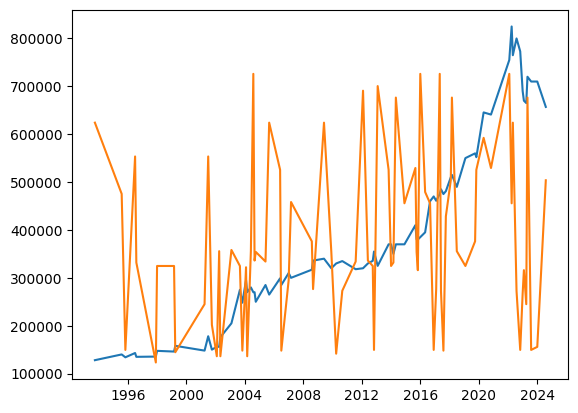

In [22]:
plot_pred_vs_actual(test, test_pred)

---

In [37]:
param_dist = {
    'n_estimators': randint(50, 5000),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.4),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.5, 0.5)
}

gbt = GradientBoostingRegressor()

In [38]:
rs = RandomizedSearchCV(estimator=gbr, 
                                   param_distributions=param_dist, 
                                   n_iter=200,
                                   cv=5,
                                   random_state=42,
                                   n_jobs=-1)
search = rs.fit(train[['lagged']], train['Nelson'].values)

In [39]:
test_pred = search.best_estimator_.predict(test[['lagged']])
print_metrics(test, test_pred)

MSE: 65489336430.196075
RMSE: 255908.84398589292
MAE: 192182.35171866618
MDAE: 186039.55790983088


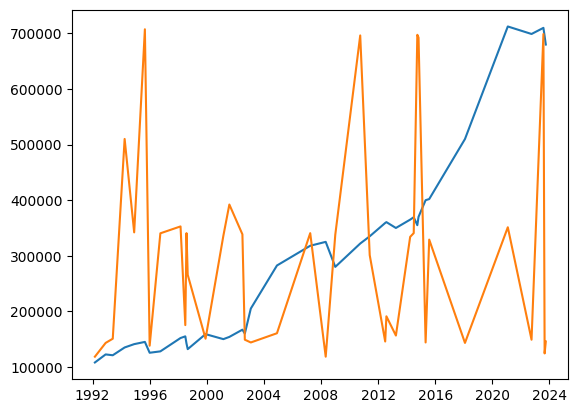

In [40]:
plot_pred_vs_actual(test, test_pred)

---

### Predicting last value

In [41]:

train, test = train_test_split(nelson.dropna()[:-1], test_size=0.1, random_state=42)

In [42]:
param_dist = {
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'max_depth': 1,
    'loss':'squared_error',
    'random_state':42,
}

In [43]:
gbt = GradientBoostingRegressor(**param_dist)

In [44]:
gbt.fit(train[['lagged']], train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(learning_rate=0.01, max_depth=1, n_estimators=5000,
                          random_state=42)

In [45]:
test_pred = gbt.predict(test[['lagged']].sort_values(by='date'))

In [46]:
print_metrics(test, test_pred)

MSE: 323384648.29959553
RMSE: 17982.898773545814
MAE: 13784.365501384325
MDAE: 10019.443262467918


In [47]:
pred_last = gbt.predict(nelson[-1:][['lagged']])
print(f'Actual value: {nelson[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 693000.0, Predicted value: 698717.1561961945


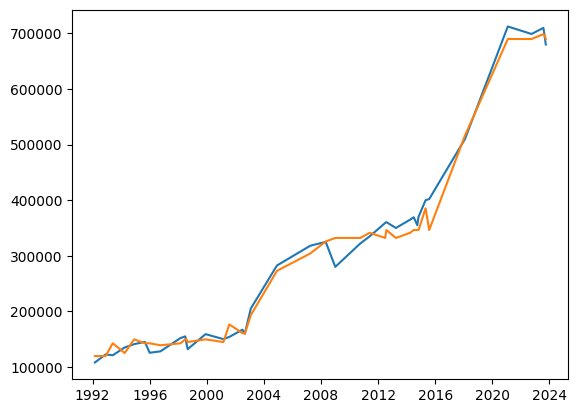

In [48]:
plot_pred_vs_actual(test, test_pred)

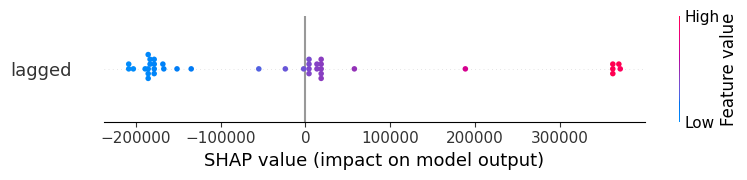

In [49]:
explainer = shap.Explainer(gbt, train[['lagged']])
shap_values = explainer.shap_values(test[['lagged']])
shap.summary_plot(shap_values, test[['lagged']])

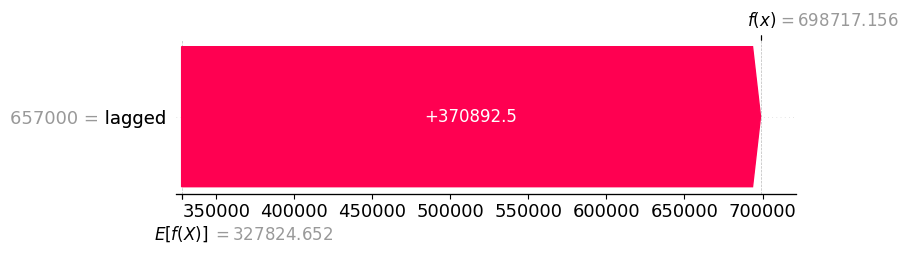

In [50]:
shap_values = explainer(nelson[-1:][['lagged']])
shap.waterfall_plot(shap_values[0])

---

## Different loss function

In [232]:
train, test = train_test_split(nelson.dropna()[:-1], test_size=0.1, random_state=42)

### Mean Absolute

In [180]:
param_dist = {
    'n_estimators': np.arange(1, 5000),
    'learning_rate': np.arange(0.01, 0.5),
    'max_depth': np.arange(1, 4),
    'loss':['absolute_error'],
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1,
    verbose=2                   
)

random_search.fit(train.drop(columns=['Nelson']), train[['Nelson']])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01]),
                                        'loss': ['absolute_error'],
                                        'max_depth': array([1, 2, 3]),
                                        'n_estimators': array([   1,    2,    3, ..., 4997, 4998, 4999])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [181]:
random_search.best_params_

{'n_estimators': 1022,
 'max_depth': 1,
 'loss': 'absolute_error',
 'learning_rate': 0.01}

In [182]:
test_pred = random_search.best_estimator_.predict(test.drop(columns=['Nelson']).sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 415704993.96977794
RMSE: 20388.84484147589
MAE: 15470.16501084457
MDAE: 10739.130737690808


In [183]:
pred_last = random_search.best_estimator_.predict(nelson.dropna()[-1:].drop(columns=['Nelson']))
print(f'Actual value: {nelson.dropna()[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 693000.0, Predicted value: 670616.6962745901


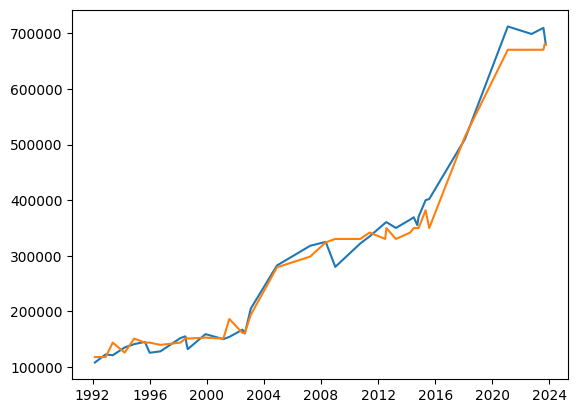

In [184]:
plot_pred_vs_actual(test, test_pred)

---

### Quantile loss

In [233]:
param_dist = {
    'n_estimators': [5000],
    'learning_rate': [0.1],
    'max_depth': [1],
    'loss':['quantile'],
    'alpha':np.arange(0.01, 1)
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1                   
)

random_search.fit(train.drop(columns=['Nelson']), train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'alpha': array([0.01]),
                                        'learning_rate': [0.1],
                                        'loss': ['quantile'], 'max_depth': [1],
                                        'n_estimators': [5000]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [234]:
random_search.best_params_

{'n_estimators': 5000,
 'max_depth': 1,
 'loss': 'quantile',
 'learning_rate': 0.1,
 'alpha': 0.01}

In [235]:
test_pred = random_search.best_estimator_.predict(test.drop(columns=['Nelson']).sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 66628668033.54281
RMSE: 258125.29522219012
MAE: 180927.42218949102
MDAE: 159863.80780559275


In [236]:
pred_last = random_search.best_estimator_.predict(nelson.dropna()[-1:].drop(columns=['Nelson']))
print(f'Actual value: {nelson.dropna()[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 693000.0, Predicted value: 122636.19219440737


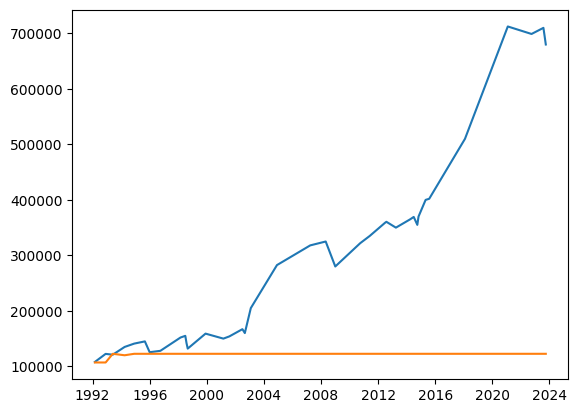

In [237]:
plot_pred_vs_actual(test, test_pred)

---

### Huber loss

In [238]:
params = {
    "n_estimators": 5000,
    "max_depth": 3,
    "learning_rate": 0.01,
    "random_state": 42,
    "loss": "huber",
    "alpha":0.6
}
gbt_huber = GradientBoostingRegressor(**params)

In [239]:
gbt_huber.fit(train.drop(columns=['Nelson']), train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(alpha=0.6, learning_rate=0.01, loss='huber',
                          n_estimators=5000, random_state=42)

In [240]:
test_pred = gbt_huber.predict(test.drop(columns=['Nelson']))
print_metrics(test, test_pred)

MSE: 64303682435.47113
RMSE: 253581.70761210503
MAE: 190671.97878489093
MDAE: 183168.6093479868


In [241]:
pred_last = random_search.best_estimator_.predict(nelson.dropna()[-1:].drop(columns=['Nelson']))
print(f'Actual value: {nelson.dropna()[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 693000.0, Predicted value: 122636.19219440737


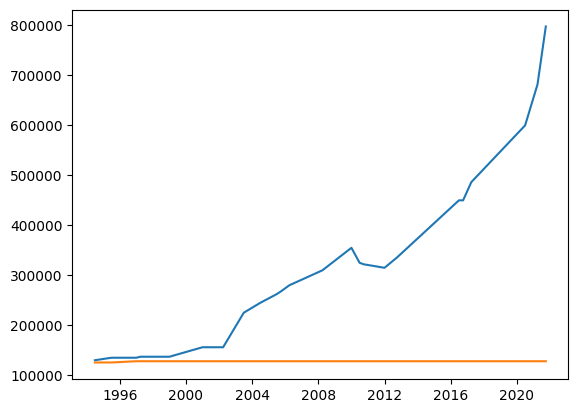

In [231]:
plot_pred_vs_actual(test, test_pred)

---

### Nelson_labour dataset

#### Without shuffling

In [187]:
df = xi.compute_xi_correlation(nelson_labour, nelson_labour.Nelson)
mask = np.where(df.Nelson.values > 0.8)
df.iloc[mask].index

Index(['Nelson', 'lagged', 'Labour force Employed (000s s.a.)',
       'Labour force Total (000s s.a.)', 'Working-age population (000s s.a.)',
       'Labour cost index (LCI) (Index)',
       'Average hourly earnings (ordinary time and overtime) ($)',
       'Private sector wages ($)', 'Public sector wages ($)'],
      dtype='object')

In [188]:
df_filtered = nelson_labour[df.iloc[mask].index]

In [189]:
train, test = train_test_split(df_filtered, test_size=0.2, shuffle=False)

In [190]:
params = {
    "n_estimators": 5000,
    "max_depth": 1,
    "learning_rate": 0.2,
    "random_state": 42
}
gbt = GradientBoostingRegressor(**params)

In [191]:
gbt.fit(train.drop(columns=['Nelson', 'lagged']), train.Nelson)

GradientBoostingRegressor(learning_rate=0.2, max_depth=1, n_estimators=5000,
                          random_state=42)

In [192]:
test_pred = gbt.predict(test.drop(columns=['Nelson', 'lagged']).sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 30702472175.850708
RMSE: 175221.20926374954
MAE: 152865.9059713804
MDAE: 159167.70007636806


In [193]:
pred_last = gbt.predict(df_filtered[-1:].drop(columns=['Nelson', 'lagged']))
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 505832.29992363194


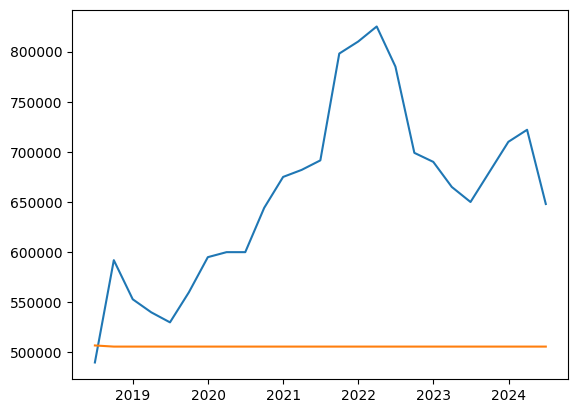

In [194]:
plot_pred_vs_actual(test, test_pred)

---

#### With shuffling

In [195]:
train, test = train_test_split(df_filtered[:-1], test_size=0.2, random_state=42)

In [196]:
params = {
    "n_estimators": 5000,
    "max_depth": 3,
    "learning_rate": 0.01,
    "random_state": 42
}

gbt = GradientBoostingRegressor(**params)

In [197]:
gbt.fit(train.drop(columns=['Nelson', 'lagged']), train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(learning_rate=0.01, n_estimators=5000,
                          random_state=42)

In [198]:
test_pred = gbt.predict(test.drop(columns=['Nelson', 'lagged']).sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 787444456.4443766
RMSE: 28061.440740709957
MAE: 17646.825492809003
MDAE: 10285.844425658506


In [199]:
pred_last = gbt.predict(df_filtered[-1:].drop(columns=['Nelson', 'lagged']))
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 720157.6188833549


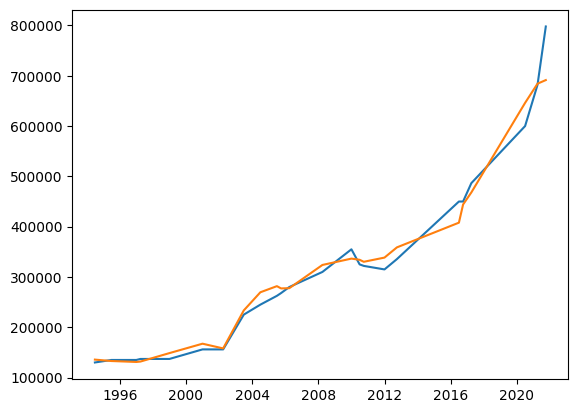

In [200]:
plot_pred_vs_actual(test, test_pred)

---

In [201]:

gbt = GradientBoostingRegressor()

param_dist = {
    'n_estimators': [1000, 5000],
    'learning_rate': [0.1],
    'max_depth': [1],
    'loss':['squared_error'],
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1                   
)

random_search.fit(train.drop(columns=['Nelson']), train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1],
                                        'loss': ['squared_error'],
                                        'max_depth': [1],
                                        'n_estimators': [1000, 5000]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [202]:
random_search.best_params_

{'n_estimators': 1000,
 'max_depth': 1,
 'loss': 'squared_error',
 'learning_rate': 0.1}

In [203]:
test_pred = random_search.best_estimator_.predict(test.drop(columns=['Nelson']).sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 903188102.6452761
RMSE: 30053.088071698658
MAE: 18964.2076993657
MDAE: 11325.593148961372


In [204]:
pred_last = random_search.best_estimator_.predict(df_filtered[-1:].drop(columns='Nelson'))
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 695312.1235678649


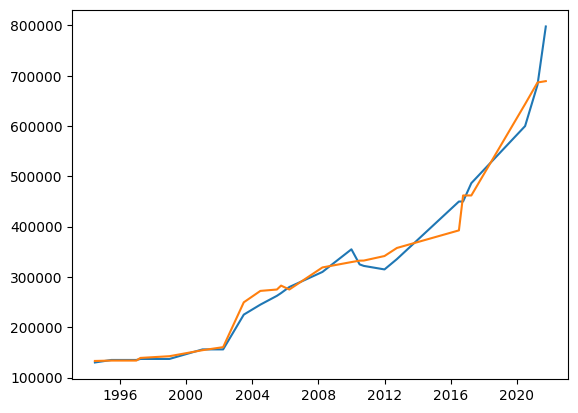

In [205]:
plot_pred_vs_actual(test, test_pred)

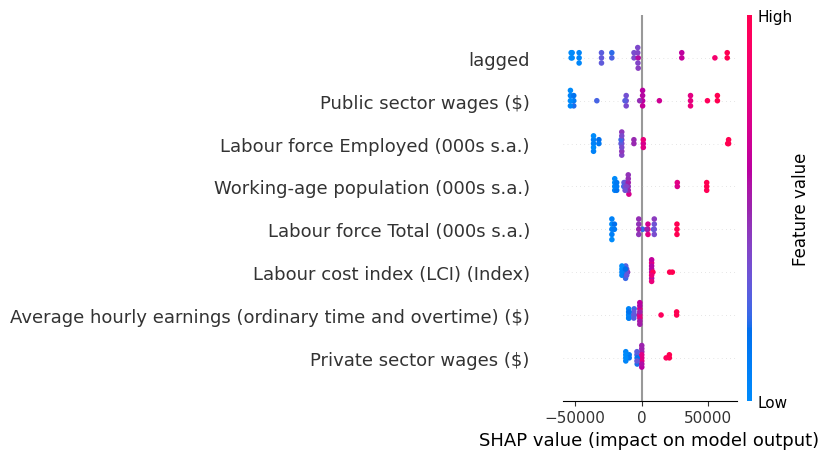

In [206]:
explainer = shap.Explainer(random_search.best_estimator_, train.drop(columns=['Nelson']))
shap_values = explainer.shap_values(test.drop(columns=['Nelson']))
shap.summary_plot(shap_values, test.drop(columns=['Nelson']))

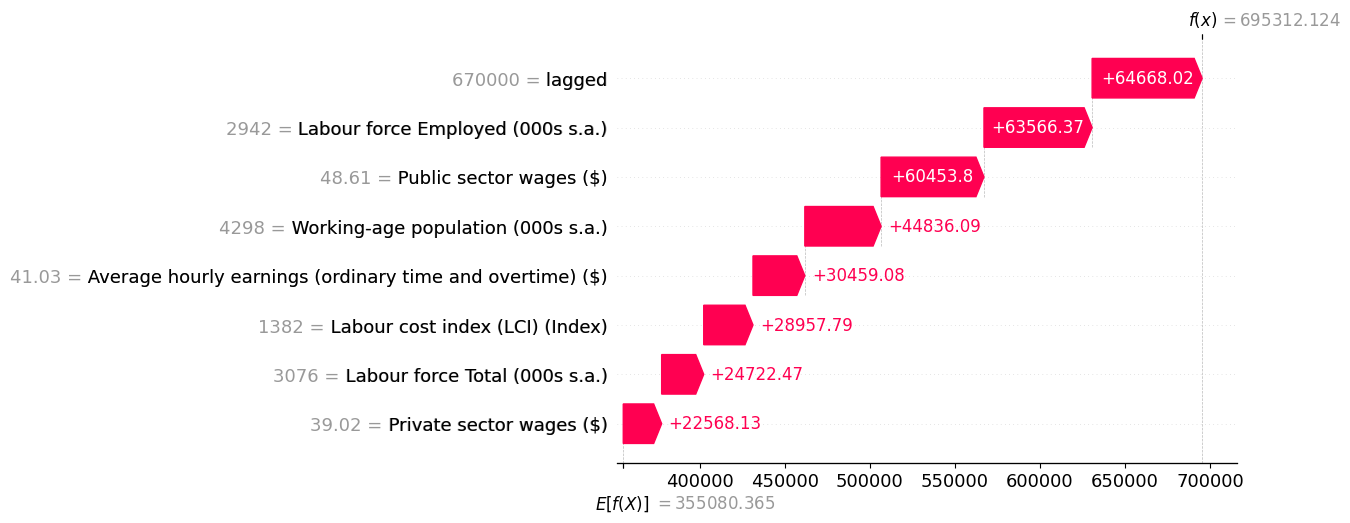

In [207]:
shap_values = explainer(df_filtered[-1:].drop(columns='Nelson'))
shap.waterfall_plot(shap_values[0])

---

### Playing around with different features

SHAP analysis shows the influence of different features, as the model seems to be overshooting the final prediction, it might be interesting to see the result of removing some more influencial features.

Drop `Public sector wages ($)`

In [208]:
shap_headers = [
    'lagged', 'Labour force Employed (000s s.a.)',
       'Labour force Total (000s s.a.)', 'Working-age population (000s s.a.)',
       'Labour cost index (LCI) (Index)',
       'Average hourly earnings (ordinary time and overtime) ($)',
       'Private sector wages ($)'
]

In [209]:
gbt = GradientBoostingRegressor()

param_dist = {
    'n_estimators': np.arange(500, 5000),
    'learning_rate': np.arange(0.01, 0.4),
    'max_depth': range(1, 4),
    'loss':['squared_error'],
    'random_state':[42]
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1,
    verbose=2                   
)

random_search.fit(train[shap_headers], train[['Nelson']])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01]),
                                        'loss': ['squared_error'],
                                        'max_depth': range(1, 4),
                                        'n_estimators': array([ 500,  501,  502, ..., 4997, 4998, 4999]),
                                        'random_state': [42]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [210]:
test_pred = random_search.best_estimator_.predict(test[shap_headers].sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 774481062.8684462
RMSE: 27829.49986737897
MAE: 16793.3182994548
MDAE: 8368.309813601765


In [211]:
pred_last = random_search.best_estimator_.predict(df_filtered[-1:][shap_headers])
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 703771.0895054507


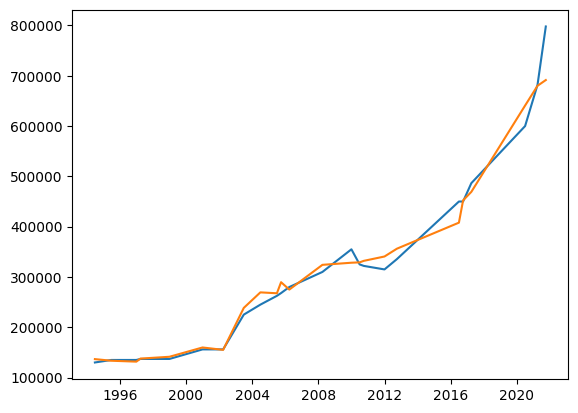

In [212]:
plot_pred_vs_actual(test, test_pred)

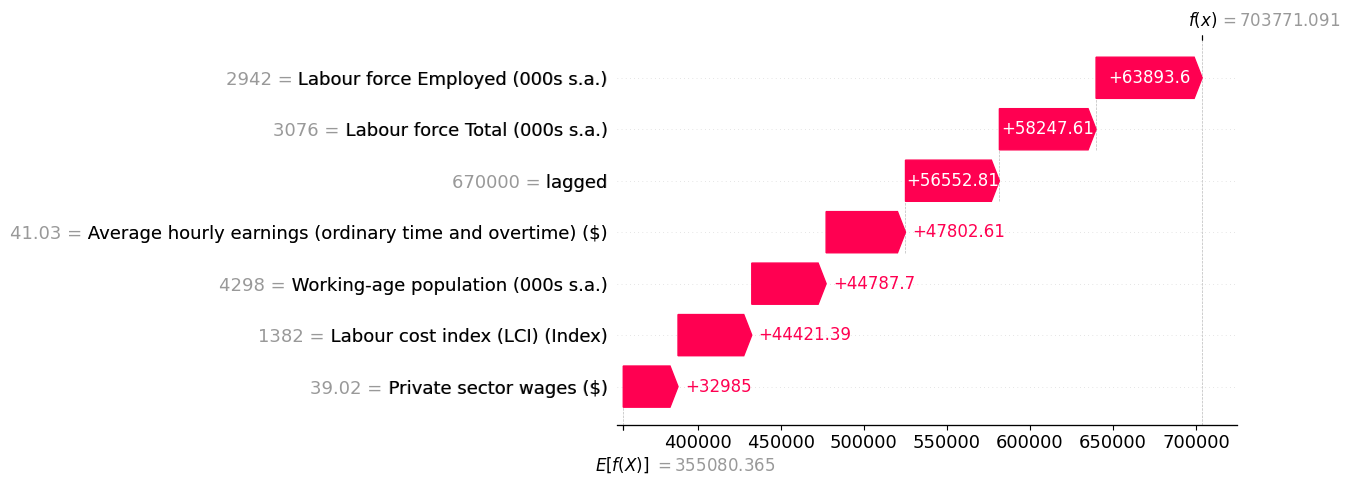

In [213]:
explainer = shap.Explainer(random_search.best_estimator_, train[shap_headers])
shap_values = explainer(df_filtered[-1:][shap_headers])
shap.waterfall_plot(shap_values[0])

---

Drop `lagged`

In [214]:
shap_headers = [
    'Public sector wages ($)', 'Labour force Employed (000s s.a.)',
       'Labour force Total (000s s.a.)', 'Working-age population (000s s.a.)',
       'Labour cost index (LCI) (Index)',
       'Average hourly earnings (ordinary time and overtime) ($)',
       'Private sector wages ($)'
]

In [215]:
gbt = GradientBoostingRegressor()

param_dist = {
    'n_estimators': np.arange(500, 5000),
    'learning_rate': np.arange(0.01, 0.4),
    'max_depth': range(1, 4),
    'loss':['squared_error'],
    'random_state':[42]
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1,
    verbose=2                   
)

random_search.fit(train[shap_headers], train[['Nelson']])
random_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


{'random_state': 42,
 'n_estimators': 667,
 'max_depth': 3,
 'loss': 'squared_error',
 'learning_rate': 0.01}

In [216]:
test_pred = random_search.best_estimator_.predict(test[shap_headers].sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 822463122.8377053
RMSE: 28678.617868330148
MAE: 18071.71172295839
MDAE: 11173.416061804106


In [217]:
pred_last = random_search.best_estimator_.predict(df_filtered[-1:][shap_headers])
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 714970.8307431501


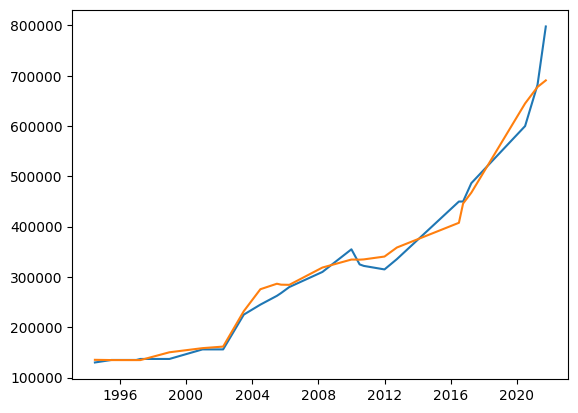

In [218]:
plot_pred_vs_actual(test, test_pred)

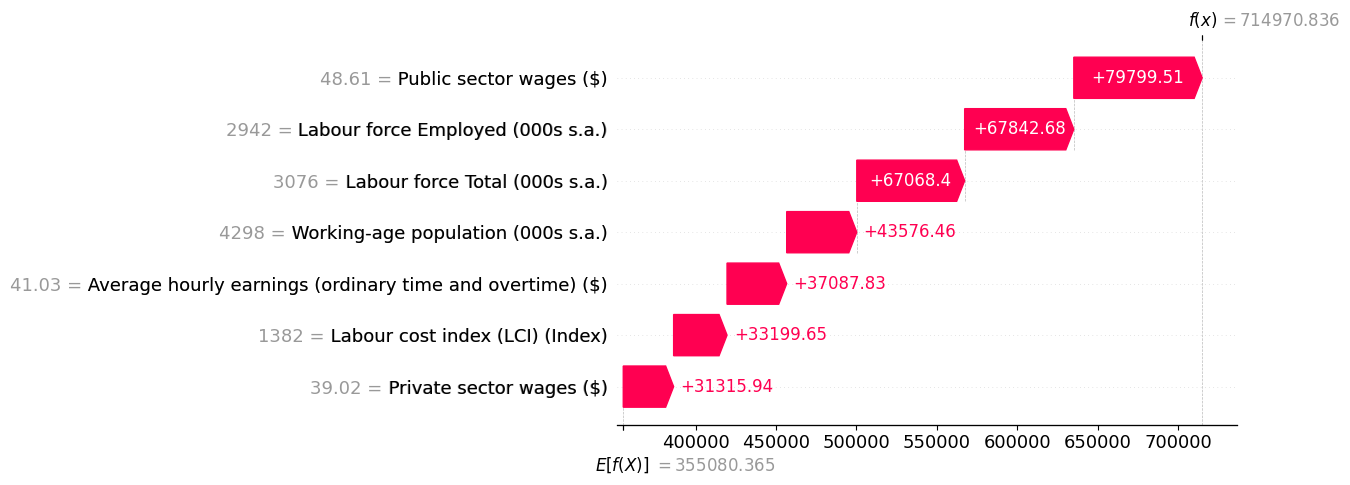

In [219]:
explainer = shap.Explainer(random_search.best_estimator_, train[shap_headers])
shap_values = explainer(df_filtered[-1:][shap_headers])
shap.waterfall_plot(shap_values[0])

---

Drop Labour force Total `(000s s.a.)`

In [220]:
shap_headers = [
    'lagged', 'Public sector wages ($)', 'Labour force Employed (000s s.a.)',
       'Working-age population (000s s.a.)',
       'Labour cost index (LCI) (Index)',
       'Average hourly earnings (ordinary time and overtime) ($)',
       'Private sector wages ($)'
]

In [221]:
gbt = GradientBoostingRegressor()

param_dist = {
    'n_estimators': np.arange(500, 5000),
    'learning_rate': np.arange(0.01, 0.4),
    'max_depth': range(1, 4),
    'loss':['squared_error'],
    'random_state':[42]
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1,
    verbose=2                   
)

random_search.fit(train[shap_headers], train[['Nelson']])
random_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


{'random_state': 42,
 'n_estimators': 774,
 'max_depth': 3,
 'loss': 'squared_error',
 'learning_rate': 0.01}

In [222]:
test_pred = random_search.best_estimator_.predict(test[shap_headers].sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 758251603.6180787
RMSE: 27536.36874422767
MAE: 16693.759075734746
MDAE: 8954.64876452781


In [223]:
pred_last = random_search.best_estimator_.predict(df_filtered[-1:][shap_headers])
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 701207.0992988164


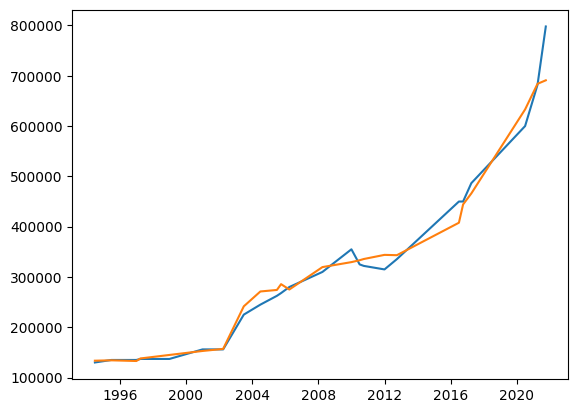

In [224]:
plot_pred_vs_actual(test, test_pred)

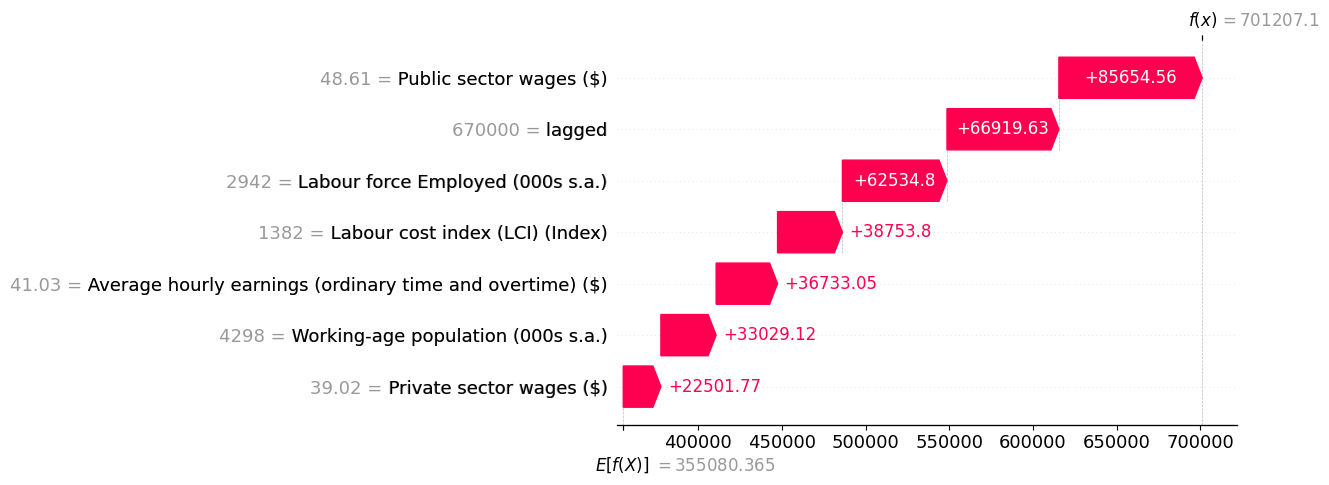

In [225]:
explainer = shap.Explainer(random_search.best_estimator_, train[shap_headers])
shap_values = explainer(df_filtered[-1:][shap_headers])
shap.waterfall_plot(shap_values[0])

# Forest


----